In [31]:
import pandas as pd
import os

from dotenv import load_dotenv
from parea import Parea

load_dotenv()


p = Parea(api_key=os.getenv("PAREA_API_KEY"))


def analysis(experiment_uuid: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    experiment_stats = p.get_experiment_stats(experiment_uuid)

    dicts = []
    for stats in experiment_stats.parent_trace_stats:
        d = {'trace_id': stats.trace_id}
        for score in stats.scores:
            d[score.name] = score.score
        dicts.append(d)

    df = pd.DataFrame(dicts)
    df_scores = df.copy()
    del df_scores['trace_id']

    df_avg = df_scores.mean().round(2)

    df_acc = df_scores.eq(df_scores['hit_rate_top_20'], axis=0).sum() / len(df_scores)
    df_fpr = df_scores.apply(lambda x: (x == 1) & (df_scores['hit_rate_top_20'] == 0)).sum() / len(df_scores)
    df_fnr = df_scores.apply(lambda x: (x == 0) & (df_scores['hit_rate_top_20'] == 1)).sum() / len(df_scores)
    df_comp = pd.concat([df_acc, df_fpr, df_fnr], axis=1, keys=['accuracy', 'fpr', 'fnr'])

    return df_avg, df_comp


jina_Q_A = analysis('65a69670-43ec-4f7e-8025-e1f04360a149')
jina_Para = analysis('c5984bad-41d4-4dbd-b3a4-e0fc03323eab')
bge_Q_A = analysis('1780cc81-825f-4273-91ee-01151473d41c')
bge_Para = analysis('e48d3ea3-1d92-498e-82bb-7967b49d6a9b')

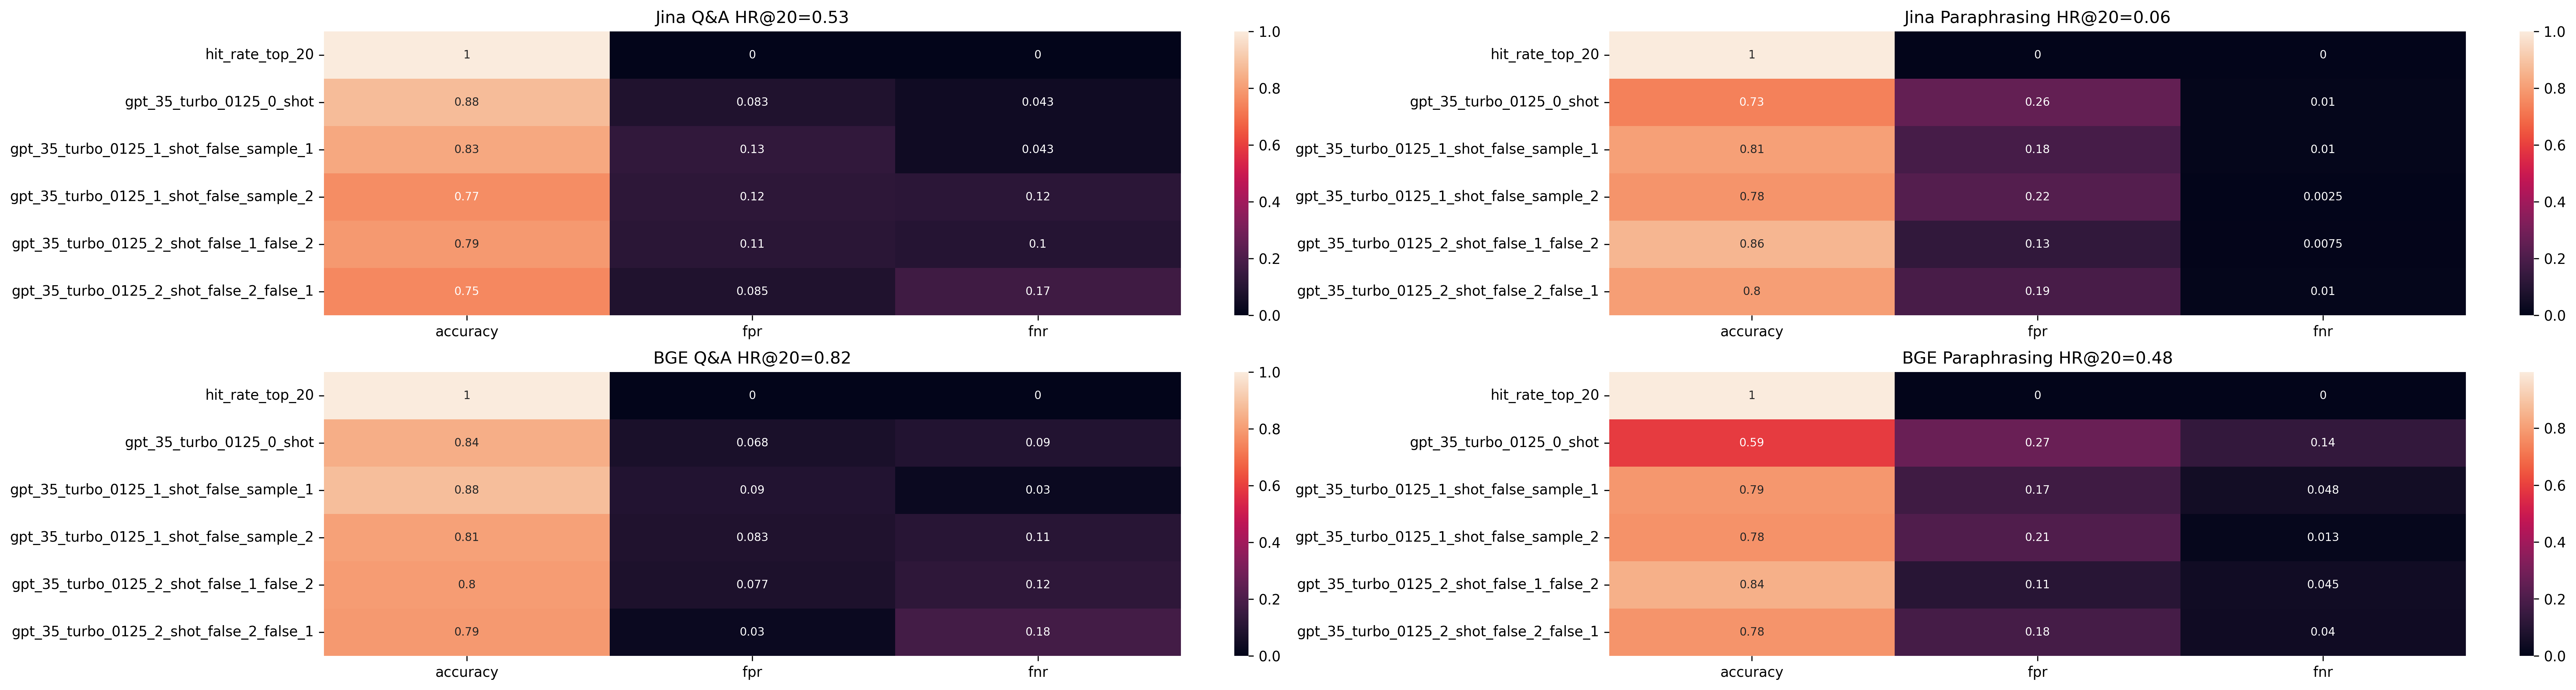

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(30, 8), dpi = 300)

sns.heatmap(jina_Q_A[1], annot=True, ax=axs[0, 0], annot_kws={"size": 8})
sns.heatmap(jina_Para[1], annot=True, ax=axs[0, 1], annot_kws={"size": 8})
sns.heatmap(bge_Q_A[1], annot=True, ax=axs[1, 0], annot_kws={"size": 8})
sns.heatmap(bge_Para[1], annot=True, ax=axs[1, 1], annot_kws={"size": 8})

axs[0, 0].set_title(f'Jina Q&A HR@20={jina_Q_A[0]["hit_rate_top_20"]}')
axs[0, 1].set_title(f'Jina Paraphrasing HR@20={jina_Para[0]["hit_rate_top_20"]}')
axs[1, 0].set_title(f'BGE Q&A HR@20={bge_Q_A[0]["hit_rate_top_20"]}')
axs[1, 1].set_title(f'BGE Paraphrasing HR@20={bge_Para[0]["hit_rate_top_20"]}')

plt.savefig('analysis-llm-eval.png')

plt.show()